In [1]:
import pandas as pd
import numpy as np
import random
from joblib import dump, load
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import statistics

In [2]:
features = pd.read_pickle('data/features_develop.pickle')
features = features.drop(['delivery_duration', 'syntetic_delivery_duration', 'products_bought'], axis=1)

Delivery info is appended after purchase - it makes no sense to take those columns as features because prediction about conversion takes place before purchase. Same with products_bought column.

In [3]:
def train_and_test(df: pd.DataFrame, preprocess, runs=1, silent=False):
    scores = []
    for i in range(runs):
        train, test = train_test_split(df, test_size=0.3)
        for func in preprocess:
            train = func(train)
            test = func(test)
        test = test.assign(**{c:False for c in list(train.columns) if c not in set(test.columns)})
        clf = svm.SVC()
        y_col = 'made_purchase'
        x_cols = train.drop(y_col, axis=1).columns
        clf.fit(train[x_cols], train[y_col])
        correct = test[y_col] == clf.predict(test[x_cols])
        scores.append(correct.sum() / len(correct))
    score = statistics.mean(scores)
    if not silent:
        print(f'The score of model B is {round(score, 4)}')
    return score

This function will be used to quickly calculate score of our model.

# Preprocessing

In [4]:
features.dtypes

made_purchase               bool
events_count               int64
product_views              int64
total_duration           float64
mean_event_duration      float64
products_viewed           object
mean_time_per_product    float64
user_id                  float64
is_female                   bool
weekday_cos_min          float64
weekday_cos_max          float64
weekday_sin_min          float64
weekday_sin_max          float64
hour_sin_min             float64
hour_sin_max             float64
hour_cos_min             float64
hour_cos_max             float64
cat_0                     object
cat_1                     object
cat_2                     object
cat_3                     object
syntetic_duration           bool
dtype: object

Feature matrix contains mostly real number or integer values but there are some non numerical types that we must take care of.

## Label encoding

Our dataset contains categorical features that must be encoded.

In [5]:
objects = features.select_dtypes(include=['object']).columns
features[objects].head()

,products_viewed,cat_0,cat_1,cat_2,cat_3
session_id,,,,,
109811.0,"{1284.0, 1287.0}",{sprzęt rtv},{video},{telewizory i akcesoria},{anteny rtv}
102058.0,"{1004.0, 1005.0, 1007.0, 1009.0, 1012.0, 1013.0}",{gry i konsole},{gry na konsole},{gry xbox 360},{}
104909.0,"{1040.0, 1041.0, 1045.0, 1046.0, 1047.0}",{gry i konsole},{gry na konsole},{gry playstation3},{}
105228.0,{1067.0},{telefony i akcesoria},{telefony komórkowe},{},{}
105640.0,{1007.0},{gry i konsole},{gry na konsole},{gry xbox 360},{}


Because those columns are sets of categories, there are at least two ways we can encode them.

### One hot encoding

In [6]:
def encode_one_hot(df):
    objects = df.select_dtypes(include=['object']).columns
    encoded_objects = []
    for col in objects:
        encoded_objects.append(pd.get_dummies(df[col].apply(str)))
    return pd.concat([df.drop(objects, axis=1)] + encoded_objects, axis=1)

In [7]:
one_hot = encode_one_hot(features)
one_hot.shape

(7771, 1812)

In [8]:
train_and_test(features.reset_index(drop=True), [encode_one_hot])

The score of model B is 0.9275


0.9275300171526587

After performing one hot encoding on columns that are sets of labels we've got many more features - those could be reduced if we encoded the presence of any particular category with a boolean flag. That way a set of two labels would have two columns with True value. This also makes sense when adding two vectors - adding a set with label A to a set with label B will result in a set that contains both label A and label B. We will try and create another DataFrame, this time using the second technique.

### Multi hot encoding

In [9]:
def multi_hot_encoder(s: pd.Series):
    result = pd.DataFrame(index=s.index)
    numpy_data = pd.DataFrame(s.apply(list).tolist()).to_numpy()
    clean = numpy_data[np.logical_not(pd.isna(numpy_data))]
    unique = np.unique(clean)    
    for c in unique:
        result[c] = s.apply(lambda r: c in r)
    return result

In [10]:
def encode_multi_hot(df):
    objects = df.select_dtypes(include=['object']).columns
    encoded_objects = []
    for col in objects:
        encoded_objects.append(multi_hot_encoder(df[col]))
    multi_hot = df.drop(objects, axis=1)
    return pd.concat([multi_hot] + encoded_objects, axis=1)    

In [11]:
multi_hot = encode_multi_hot(features)
multi_hot.shape

(7771, 118)

That method returned an encoded dataset with as few as 118 features.

In [12]:
train_and_test(features.reset_index(drop=True), [encode_multi_hot])

The score of model B is 0.9318


0.9318181818181818

Although model a with multi encoding works way faster than with one hot encoding (because of less features used in calculations) its score is very similar. That being said we will stick with it just because it's faster and easier to work with.

In [13]:
preprocessing = [encode_multi_hot]

## Scaling

In [14]:
def normalize_numeric(df):
    numeric = df.select_dtypes(include=['int64', 'float64']).columns
    scaled_numeric = (df[numeric] - df[numeric].mean()) / df[numeric].std()
    scaled = df.drop(numeric, axis=1)
    return pd.concat([scaled, scaled_numeric], axis=1).reset_index(drop=True)

In [15]:
scaled = normalize_numeric(features)
scaled.shape

(7771, 22)

In [16]:
train_and_test(scaled.reset_index(drop=True), preprocessing + [normalize_numeric])

The score of model B is 0.964


0.9639794168096055

Normalization helped with our classification problem and now the final score is much higher.

In [38]:
preprocessing = [encode_multi_hot, normalize_numeric]

# Feature selection

After dataset encoding now it's time to select only those features that are most informative. Deleting unwanted noise-producing columns will speed up calculations and improve overall model score.

In [18]:
preprocessed = features
for func in preprocessing:
    preprocessed = func(preprocessed)

## Correlation

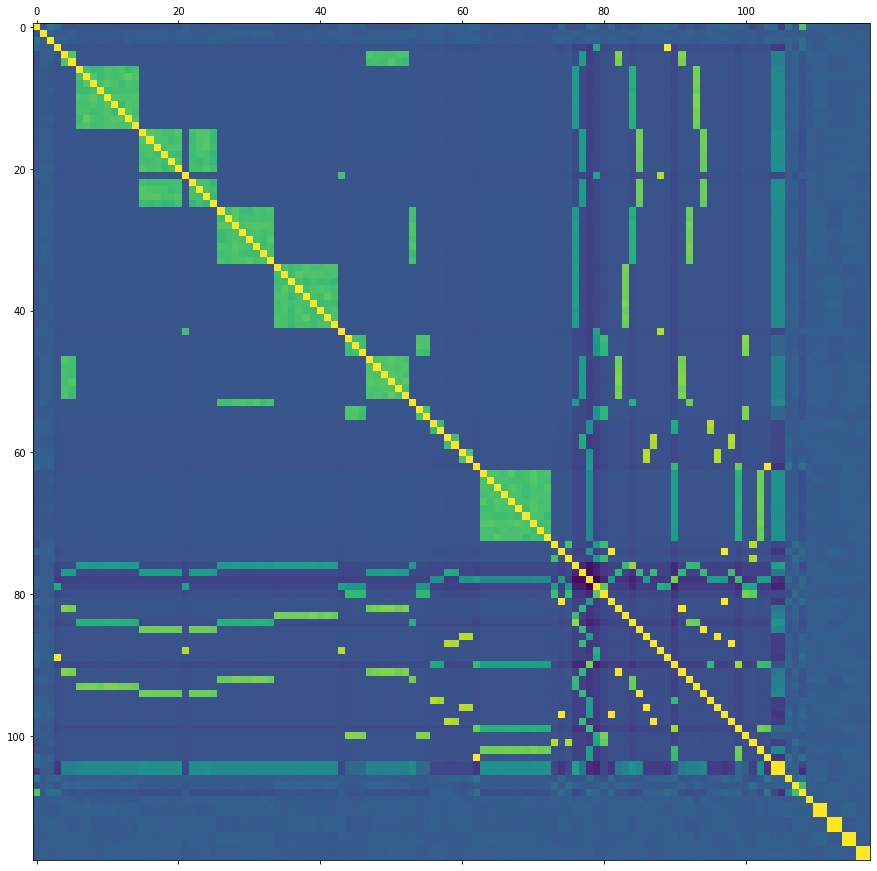

In [19]:
f = plt.figure(figsize=(15, 15))
plt.matshow(preprocessed.corr(), fignum=f.number)
plt.show()

This plot shows us that there are features that are not really helpful with our problem. Deleting them will not only speed up learning/predicting processes but also can lead to better performance and scores. Further analysis will be based on mutual information and correlation of the columns in our dataset.

## Mutual information / correlation table

In [20]:
columns = preprocessed.columns.to_series()
mutual_info = columns.apply(lambda c: metrics.mutual_info_score(preprocessed[c], preprocessed.made_purchase))
corr = features.corr().made_purchase
information = pd.DataFrame(data={'mi': mutual_info, 'co': corr.abs(), 'both': mutual_info * corr.abs()})
information.sort_values(by='both', ascending=False)

,mi,co,both
made_purchase,6.214473e-01,1.000000,0.621447
mean_time_per_product,3.896305e-01,0.608291,0.237009
total_duration,1.866328e-01,0.160572,0.029968
mean_event_duration,2.038935e-01,0.037262,0.007597
events_count,1.053808e-01,0.056347,0.005938
...,...,...,...
telewizory i akcesoria,2.179986e-04,NaN,NaN
zestawy głośnomówiące,6.095102e-07,NaN,NaN
zestawy słuchawkowe,3.283410e-03,NaN,NaN
anteny rtv,7.144750e-04,NaN,NaN


Having this information, now it's time to test most promissing subsets of features and pick the best result in terms of overall model score.

## Testing features

In [21]:
def take_n_best(df, n):
    return 

In [22]:
def test_features(df: pd.DataFrame, indicator: pd.Series):
    results = pd.DataFrame(columns=['features', 'score'])
    for f in range(len(df.columns), 2, -5):
        best = indicator.nlargest(f).index
        take_n_best = lambda df: df[best]
        score = train_and_test(features.reset_index(drop=True), preprocessing + [take_n_best], runs=1, silent=True)
        results = results.append({'count': int(f-1), 'score': score, 'features': best}, ignore_index=True)
    return results

### Based on mutual information and correlation

In [23]:
results_both = test_features(preprocessed, information.both)
results_both.sort_values(by='score', ascending=False).head(2)

,features,score,count
22,"Index(['made_purchase', 'mean_time_per_product...",0.996998,7.0
21,"Index(['made_purchase', 'mean_time_per_product...",0.986707,12.0


### Based on correlation

In [24]:
results_co = test_features(preprocessed, information.co)
results_co.sort_values(by='score', ascending=False).head(2)

,features,score,count
22,"Index(['made_purchase', 'mean_time_per_product...",0.997427,7.0
21,"Index(['made_purchase', 'mean_time_per_product...",0.995283,12.0


### Based on mutual information

In [25]:
results_mi = test_features(preprocessed, information.mi)
results_mi.sort_values(by='score', ascending=False).head(2)

,features,score,count
21,"Index([ 'made_purchase', 'mean_time_per...",0.996998,12.0
19,"Index([ 'made_purchase', ...",0.995712,22.0


## Comparison

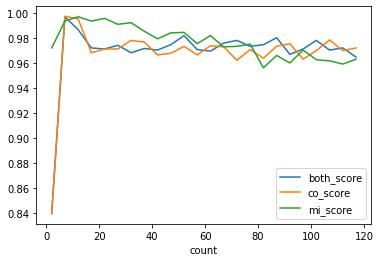

In [26]:
res = []
res.append(results_both[['count']])
res.append(results_both[['score']].add_prefix('both_'))
res.append(results_co[['score']].add_prefix('co_'))
res.append(results_mi[['score']].add_prefix('mi_'))
pd.concat(res, axis=1).plot(x='count', y=['both_score', 'co_score', 'mi_score'])

In [44]:
all_results = pd.concat([results_both, results_co, results_mi], axis=0).reset_index()
best_result = all_results.loc[all_results.score.idxmax()]
best_result = best_result.append(pd.Series(['made_purchase'], index=['y']))
print(f'Best results obtained with {int(best_result["count"])} features')
best_features = preprocessed[best_result.features]
preprocessing = [encode_multi_hot, normalize_numeric, lambda df: df[best_result.features]]

Best results obtained with 7 features


# Final training

In [48]:
final_train = pd.read_pickle('data/features_develop.pickle')
final_train = final_train.drop(['delivery_duration', 'syntetic_delivery_duration', 'products_bought'], axis=1)
for func in preprocessing:
    final_train = func(final)
y_col = 'made_purchase'
clf = svm.SVC()
clf.fit(final_train.drop(y_col, axis=1), final_train[y_col])

SVC()

# Final testing

In [ ]:
final_testing = pd.read_pickle('data/features_prod.pickle')
final_testing = final_testing.drop(['delivery_duration', 'syntetic_delivery_duration', 'products_bought'], axis=1)
for func in preprocessing:
    final_testing = func(final)
final_testing.assign(**{c:False for c in list(final_training.columns) if c not in set(final_testing.columns)})
y_col = 'made_purchase'
correct = final_testing[y_col] == clf.predict(final_testing[x_cols])
score = correct.sum() / len(correct)

# Saving model

In [29]:
best_result

index                                                      22
features    Index(['made_purchase', 'mean_time_per_product...
score                                                0.997427
count                                                       7
y                                               made_purchase
dtype: object

In [30]:
dump(clf, 'data/model_b.joblib') 
best_result.to_pickle('data/model_b_metadata.pickle')
preprocessed[best_result.features].describe().to_pickle('data/model_b_data.pickle')